# Исследование продаж интернет-магазина компьютерных игр

## Описание проекта

Для интернет-магазина компьютерных игр требуется провести анализ и выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

Данные за 2016 год могут быть неполными.  

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

В нашем распоряжении файл `games.csv` с информацией о продажах игр, оценках пользователей и экспертов, жанрах и платформах.  
- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board).  

**Цель исследования:** выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**План проведения исследования:**  
- загрузить и изучить имеющиеся данные,
- определить актуальный период и провести исследовательский анализ данных,
- определить профиль пользоватлея каждого региона,
- проверить гипотезы о равенстве пользовательских оценок платформ и жанров,
- сделать общие выводы.

## Базовый анализ и предварительная обработка данных  

Изучим содержимое файла `games.csv`.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [ ]:
try:
    df = pd.read_csv('/datasets/games.csv')

except FileNotFoundError:
    print("Файл не найден")
except pd.errors.EmptyDataError:
    print("Файл пустой или не содержит данных")
except pd.errors.ParserError:
    print("Ошибка при чтении файла")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [ ]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


В датафрейме 16715 строк и 11 колонок.  
Есть пропущенные значения.  
Требуется привести названия колонок к snake_case.

---

In [ ]:
# Приведем названия колонок к нижнему регистру
df = df.rename(columns=str.lower)

---
Проверим, есть ли дублирующиеся строки.

In [ ]:
print('Количество строк-дубликатов:', df.duplicated().sum())

Количество строк-дубликатов: 0


---
Посмотрим на пропущенные значения в абсолютном выражении и процентах.

In [ ]:
missed1 = df.isna().sum()
missed2 = (df.isna().sum() * 100 / df.shape[0]).round(2)
missed = pd.concat([missed1, missed2], axis=1)
missed.columns = ['missed_abs', 'missed_%']
missed

,missed_abs,missed_%
name,2,0.01
platform,0,0.00
year_of_release,269,1.61
genre,2,0.01
na_sales,0,0.00
eu_sales,0,0.00
jp_sales,0,0.00
other_sales,0,0.00
critic_score,8578,51.32
user_score,6701,40.09


Больше всего пропущенных значений - в колонках с оценками:
- `user_score` - 51,3% пропущенных значений,
- `critic_score` - около 54,6%,
- `rating` - около 40,5%.  


---

Рассмотрим категориальные переменные и поищем неявные дубликаты.  
Начнем с колонки `name`.

In [ ]:
print('Количество уникальных наименований игр:', df['name'].nunique())

Количество уникальных наименований игр: 11559


Уникальных наименований игр очень много и искать потенциальные неявные дубликаты вручную нецелесообразно.
Просто приведем наименования игр к нижнему регистру и удалим знаки препинания (оставим только буквы и цифры).

In [ ]:
pattern = r'[^\w\s]'
df['name'] = df['name'].str.replace(pattern, '').str.lower().str.strip()

In [ ]:
print('Осталось уникальных наименований игр:', df['name'].nunique())

Осталось уникальных наименований игр: 11535


Мы избавились от 24 неявных дубликатов в названиях игр.

---

In [ ]:
df['platform'].sort_values().unique()

array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG',
       'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP',
       'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype=object)

Неявных дубликатов в названиях платформ нет.

---

In [ ]:
df['genre'].sort_values().unique()

array(['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle',
       'Racing', 'Role-Playing', 'Shooter', 'Simulation', 'Sports',
       'Strategy', nan], dtype=object)

Неявных дубликатов в названиях жанров нет.

---

In [ ]:
df['rating'].sort_values().unique()

array(['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'RP', 'T', nan], dtype=object)

In [ ]:
df['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

Рассмотрим эти обозначения внимательнее.  

- _«AO» («Adults Only 18+»)_ — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет.
- _«E» («Everyone»)_ — «Для всех»: Содержание вполне подходит для всех возрастов.
- _«E10+» («Everyone 10 and older»)_ — «Для всех от 10 лет и старше».
- _«EC» («Early childhood»)_ — «Для детей младшего возраста»: Игра подходит для детей от 3 лет.
- _«K-A» («Kids to Adults»)_ - устаревший аналог «E» («Everyone»).
- _«M» («Mature»)_ — «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет.
- _«RP» («Rating Pending»)_ — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга.
- _«T» («Teen»)_ — «Подросткам»: Игра подходит для лиц от 13 лет.  


Как мы видим, «K-A» - это, по сути, тот же самый рейтинг, что и «E». Заменим это обозначение.  
Игра с рейтингом «AO» всего одна и этот рейтинг во многом похож на «M». Заменим и это обозначение.
Игр с рейтингом "EC" всего 8 и мы можем объединить их с рейтингом "E"
«RP» означает отсуствие рейтинга. Используем это обозначение для заполнения пропущенных значений.

In [ ]:
df['rating'] = df['rating'].replace(['K-A', 'EC', 'AO'], ['E', 'E', 'M']).fillna('RP')

In [ ]:
df['rating'].value_counts()

RP      6765
E       4000
T       2961
M       1564
E10+    1419
Name: rating, dtype: int64

Заполним пропуски в `year_of_release`, насколько это возможно.  
Каждому сочетанию "название игры" + "платформа" соответствует какой-то один определенный год релиза. В этом случае мы можем написать функцию, которая будет заполнять пропущенные значения в колонке с годом релиза, если эти значения заполнены для игры с тем же названием и на той же платформе.

In [ ]:
def fill_missing_year(df):
    for index, row in df.iterrows():
        if pd.isna(row['year_of_release']):
            same_combination = df[(df['name'] == row['name']) & (df['platform'] == row['platform'])]
            same_year = same_combination['year_of_release'].dropna().unique()
            if len(same_year) == 1:
                df.at[index, 'year_of_release'] = same_year[0]
    return df

In [ ]:
df = fill_missing_year(df)

In [ ]:
# Проверим количество пропусков заново.
missed1 = df.isna().sum()
missed2 = (df.isna().sum() * 100 / df.shape[0]).round(2)
missed = pd.concat([missed1, missed2], axis=1)
missed.columns = ['missed_abs', 'missed_%']
missed

,missed_abs,missed_%
name,2,0.01
platform,0,0.00
year_of_release,267,1.60
genre,2,0.01
na_sales,0,0.00
eu_sales,0,0.00
jp_sales,0,0.00
other_sales,0,0.00
critic_score,8578,51.32
user_score,6701,40.09


Получилось заполнить всего два пропуска в колонке с годами релиза.

---

Проверим наличие дубликатов по ключевым столбцам `name`, `platform` и `year_of_release`.

In [ ]:
df[df.duplicated(subset=['name', 'platform', 'year_of_release'], keep=False)].sort_values(by='name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,madden nfl 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
16230,madden nfl 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E
1745,sonic the hedgehog,PS3,2006.0,Platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+
4127,sonic the hedgehog,PS3,2006.0,Platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+
475,wwe smackdown vs raw 2006,PS2,2005.0,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,RP
488,wwe smackdown vs raw 2006,PS2,2005.0,Fighting,1.45,1.11,0.04,0.33,NaN,NaN,RP
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,RP
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,RP


Мы видим 3 неполных дубликата - `madden nfl 13`, `sonic the hedgehog`, `wwe smackdown vs raw 2006`, а также 2 строчки с отсутствующим названием и жанром.  

Строчки с индексами `16230` и `4127` очевидно ошибочные - согласно им, игры продавались только в региона EU.  
Также, изучив данные по продажам игры [WWE SmackDown! vs. RAW 2006 Sales](https://arcadetemple.com/wwe-smackdown-vs-raw-2006-sales-numbers-2/), можем утверждать, что строчка с индексом `475` также ошибочная.

Удалим ошибочные строки и строки с отсутствующими названиями игр.

In [ ]:
df = df.drop([16230, 4127, 475, 659, 14244])

In [ ]:
print('В датафрейме осталось', df.shape[0], 'строк')


В датафрейме осталось 16710 строк


---
Проверим подозрительные значения количественных переменных.

In [ ]:
df.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
year_of_release,16443.0,2006.486,5.876,1980.0,2003.0,2007.00,2010.00,2016.00
na_sales,16710.0,0.263,0.814,0.0,0.0,0.08,0.24,41.36
eu_sales,16710.0,0.145,0.503,0.0,0.0,0.02,0.11,28.96
jp_sales,16710.0,0.078,0.309,0.0,0.0,0.00,0.04,10.22
other_sales,16710.0,0.047,0.187,0.0,0.0,0.01,0.03,10.57
critic_score,8135.0,68.969,13.936,13.0,60.0,71.00,79.00,98.00


Данные в датафрейме представлены в диапазоне с 1980 по 2016 годы.  


Отрицательных значений продаж нет.  
Есть нулевые значения продаж, но такое возможно - игра, возможно, не продавалась на данном рынке.


Диапазон оценок критиков - от 13 до 98. Оценка производиласть по 100-балльной системе.  
Диапазон оценок пользователей - от 0 до 9,7. Оценка производиласть по 10-балльной системе.

---

In [ ]:
df['user_score'].value_counts().head()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
Name: user_score, dtype: int64

В колонке `user_score` есть около 2,5 тыс. обозначений _tbd_. Это обозначает, что количественная оценка у игры в настоящее время отсутствует. Удалим их как не несущие никакого полезного смысла и изменим тип данных этой колонки на _float_.    


Тип данных колонки `year_of_release` заменим на целочисленный _Int64_, поскольку год - это всегда целое число.

In [ ]:
df['user_score'] = df['user_score'].replace('tbd', np.nan)
df['user_score'] = df['user_score'].astype(float)

df['year_of_release'] = df['year_of_release'].astype('Int64')

df.dtypes

name                object
platform            object
year_of_release      Int64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
dtype: object

---
Рассмотрим пропуски в оценках.  
Сгруппируем данные по платформам и посчитаем, какой процент от общего количества оценок составляют пропуски.

In [ ]:
# считаем количество имеющихся оценок по платформам
score_actual = df.groupby('platform')[['critic_score', 'user_score']].count()

# считаем количество отсутствующих оценок по платформам
score_missing = df.groupby('platform')[['critic_score', 'user_score']].apply(lambda x: x.isna().sum())

# сводим полученные данные в одну таблицу и переименовываем колонки
score = pd.concat([score_actual, score_missing], axis=1).reset_index()
score.columns = ['platform', 'critic_score_actual', 'user_score_actual', 'critic_score_missing', 'user_score_missing']

# считаем и добавляем в датафрейм процент, который составляют отсутствующие оценки к их общему количеству.
score['critic_score_missing_%'] = (score['critic_score_missing'] * 100\
                                   / (score['critic_score_missing'] + score['critic_score_actual'])).round(1)
score['user_score_missing_%'] = (score['user_score_missing'] * 100\
                                   / (score['user_score_missing'] + score['user_score_actual'])).round(1)
score = score.sort_values(by='critic_score_missing_%', ascending=False)

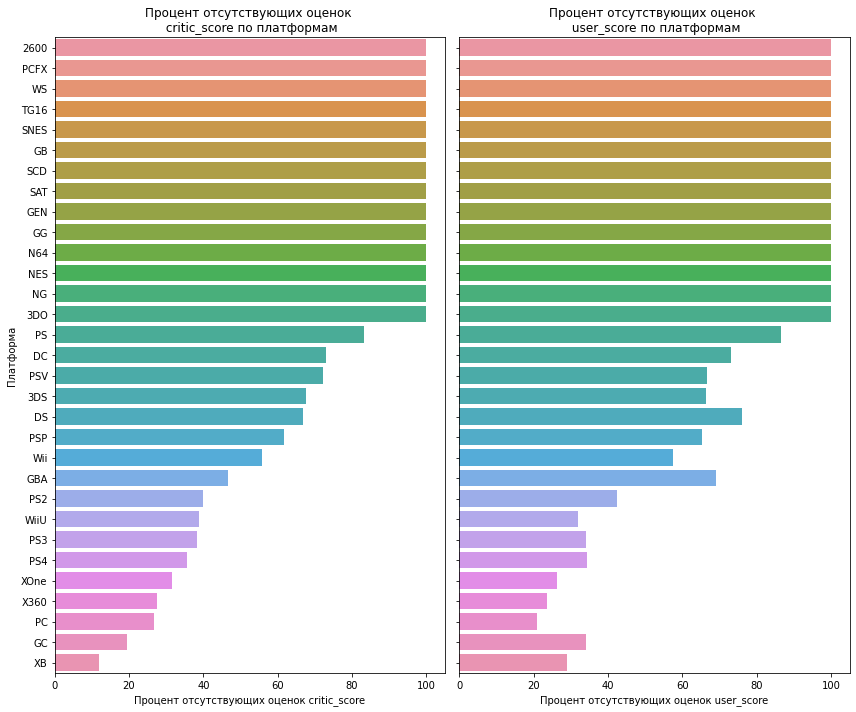

In [ ]:
# визуализируем рассчитанные проценты отсутствующих оценок по платформам на графике.
fig, axes = plt.subplots(1, 2, figsize=(12, 10), sharey=True)

sns.barplot(y='platform', x='critic_score_missing_%', data=score, orient='horizontal', ax=axes[0])
axes[0].set_xlabel('Процент отсутствующих оценок critic_score')
axes[0].set_ylabel('Платформа')
axes[0].set_title('Процент отсутствующих оценок \n critic_score по платформам')

sns.barplot(y='platform', x='user_score_missing_%', data=score, orient='horizontal', ax=axes[1])
axes[1].set_xlabel('Процент отсутствующих оценок user_score')
axes[1].set_ylabel('')
axes[1].set_title('Процент отсутствующих оценок \n user_score по платформам')

plt.tight_layout()
plt.show()

Мы обнаружили, что для игр, выпущенных на 14 платформах, нет ни одной оценки.

---
Рассмотрим количество выпускаемых игр по годам и сравним его с количеством игр по годам, для которых отсутствует оценка

In [ ]:
df['year_of_release'].nunique()*2

74

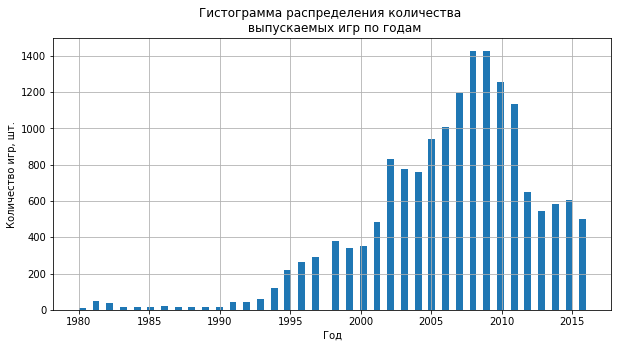

In [ ]:
plt.figure(figsize=(10,5))
df['year_of_release'].hist(bins=74)

plt.title('Гистограмма распределения количества \n выпускаемых игр по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр, шт.')
plt.show()

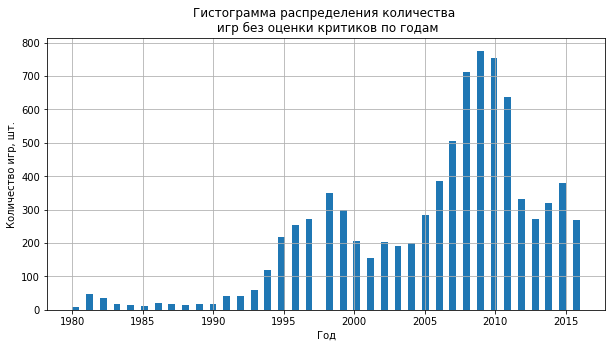

In [ ]:
plt.figure(figsize=(10,5))
no_critic_score = df[df['critic_score'].isna()]
no_critic_score['year_of_release'].hist(bins=74)

plt.title('Гистограмма распределения количества \n игр без оценки критиков по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр, шт.')
plt.show()

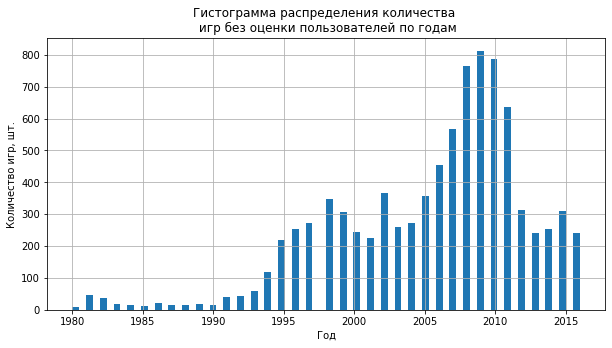

In [ ]:
plt.figure(figsize=(10,5))
no_user_score = df[df['user_score'].isna()]
no_user_score['year_of_release'].hist(bins=74)

plt.title('Гистограмма распределения количества \n игр без оценки пользователей по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр, шт.')
plt.show()

Как мы видим из гистограмм, их конфигурации похожи - сначала идет постепенный рост с пиком примерно на 2009-2021 годах, затем падение. Можем сделать умозаключение, что примерно половина выпускаемых игр может не получать оценку пользователей и критиков.     

Либо в источнике, из которого берется информация для нашего датасета, нет информации об оценках примерно половины выпускаемых игр.

---
Создадим колонку с суммарными продажами.

In [ ]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [ ]:
df['total_sales'].describe()

count    16710.000000
mean         0.533202
std          1.548298
min          0.000000
25%          0.060000
50%          0.170000
75%          0.470000
max         82.540000
Name: total_sales, dtype: float64

**Резюме подраздела:**
- в имеющемся файле 16715 строк и 11 колонок,
- мы привели названия колонок в соответствие со snake_case,
- строк-дубликатов нет,
- количественные переменные без подозрений,
- удалили 24 неявных дубликата в категориальных переменных,
- изменили типы данных в двух колонках:
    - `user_score` на _float_, поскольку это вещественное число,
    - `year_of_release`на _Int64_, поскольку год - это всегда целое число,
- в 5 колонках есть пропущенные значения,
- в колонке `user_score` есть обозначения _tbd_, что означает, вероятно, _To Be Determined_. Т.е., оценка игре не выставлена и эту аббервиатуру мы удалили и считаем за пропуск,
- заполнили 2 пропуска в колонке `year_of_release`,
- перегруппировали рейтинги и заполнили пропуски в этой колонке рейтингом "RP",
- удалили 3 строки с частичными дубликатами и 2 строки с пропущенными названиями игр,
- оставшиеся пропуски заполнять не будем, поскольку критерии заполнения не ясны, а заполнять пропуски медианой (т. е., по сути, случайным числом) особой необходимости нет,
- обнаружили, что у 14 платформ отсутствуют оценки критиков и пользоватлелей,
- создали дополнительную колонку `total_sales` с суммарной выручкой по всем регионам.

## Исследовательский анализ данных

### Сколько игр выпускалось в разные годы?

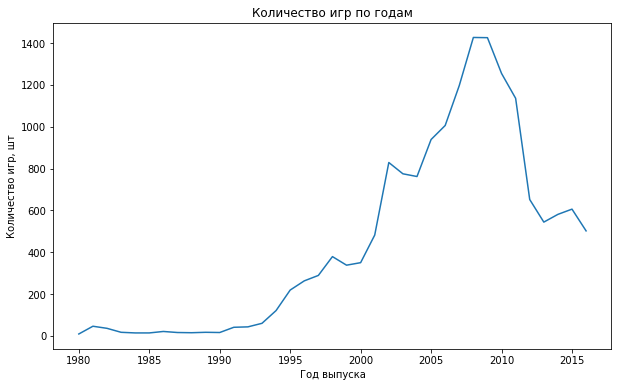

In [ ]:
# построим график количества релизов игр по годам.

releases = df['year_of_release'].value_counts().reset_index()
releases = releases.rename(columns={'index': 'year_of_release', 'year_of_release': 'games_qty'})

plt.figure(figsize=(10, 6))
sns.lineplot(x='year_of_release', y='games_qty', data=releases)

plt.xlabel('Год выпуска')
plt.ylabel('Количество игр, шт')
plt.title('Количество игр по годам')

plt.show()

До 1990 года количество выпускаемых игр практически не менялось.  
Затем начался заметный рост с пиком, приходящимся на 2008-2009 годы, когда выпускалось более 1400 игр ежегодно.  
В 2013 году произошло резкое падение количества примерно до 600 игр.   
После этого  количество ежегодных релизов игр приняло нисходящий характер.

### Как менялись продажи по платформам?

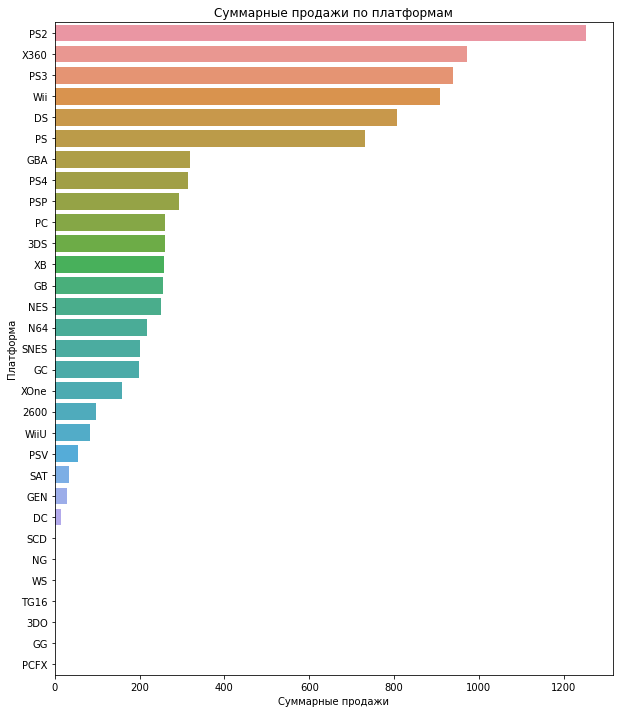

In [ ]:
# Определим список платформ с наибольшими суммарными продажами.

platforms = df.groupby('platform')['total_sales']\
                .sum().reset_index()\
                .sort_values('total_sales', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(y='platform', x='total_sales', data=platforms, orient='horizontal')

plt.xlabel('Суммарные продажи')
plt.ylabel('Платформа')
plt.title('Суммарные продажи по платформам')

plt.show()


На графике явно выделяется 6 платформ с наибольшими суммарными продажами: _PS2, X360, PS3, Wii, DS и PS_.

---

Платформа Nintendo DS выпускалась с 2004 года. Таким образом, данные по этой платформе за 1985 год можно удалить как аномальные.

In [ ]:
df = df.drop(df[(df['platform'] == 'DS') & (df['year_of_release'] == 1985)].index)

In [ ]:
# отфильтруем строки только с выявленными топ-6 платформ.

df_platforms = df[df['platform'].isin(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS'])]
df_platforms = df_platforms.groupby(['platform', 'year_of_release'])['total_sales'].sum().reset_index()

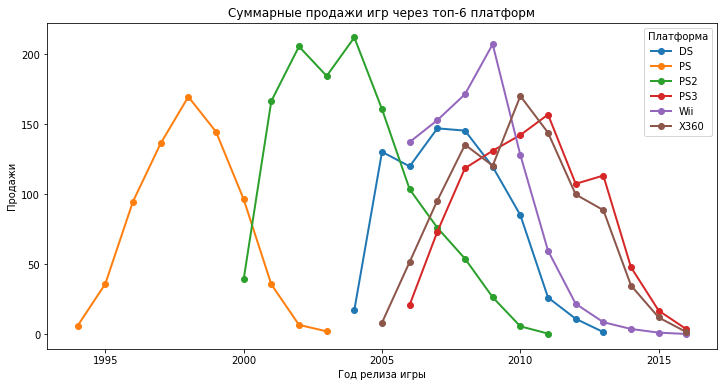

In [ ]:
# визуализируем продажи игр через топ-6 платформ на графике.
pivot_table = df_platforms.pivot('platform', 'year_of_release', 'total_sales')

pivot_table.T.plot(marker='o', linestyle='-', linewidth=2, figsize=(12, 6))

plt.xlabel('Год релиза игры')
plt.ylabel('Продажи')
plt.title('Суммарные продажи игр через топ-6 платформ')

plt.legend(title='Платформа', bbox_to_anchor=(1, 1))
plt.xticks(rotation=0)
plt.show();


На гравике явно видны жизненные циклы платформ - как правило, продажи через платформы происходят в течение примерно 10-12 лет с пиком продаж в середине цикла.  

В качестве актуального периода для прогноза на 2017 год мы можем взять данные за последние 3 года (т.е., с 2014 по 2016 годы). Более ранние данные проигнорируем как неактуальные.  

---

### Какие актуальные платформы лидируют по продажам?

In [ ]:
# создадим новый датафрейм для расчетов, в котором оставим данные не старше 2014 года.

df_filtered = df[df['year_of_release'] >= 2014]

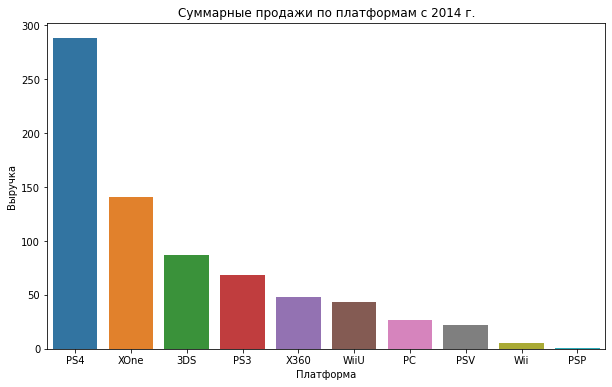

In [ ]:
df_revenue = df_filtered.groupby('platform')['total_sales']\
                        .sum().reset_index()\
                        .sort_values(by='total_sales', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='platform', y='total_sales', data=df_revenue)

plt.xlabel('Платформа')
plt.ylabel('Выручка')
plt.title('Суммарные продажи по платформам с 2014 г.')

plt.show()

Наибольшую выручку от продажи игр в рассматриваемый период принесли платформы _PS4, XOne_ и _3DS_.

---

In [ ]:
pivot_platforms = df[df['year_of_release'] >= 2007].pivot_table(index='platform',
                                          columns='year_of_release',
                                          values='total_sales',
                                          aggfunc='sum')

Рассмотрим последние 10 лет и определим, какие платформы находятся в начале или середине своего жизненного цикла.

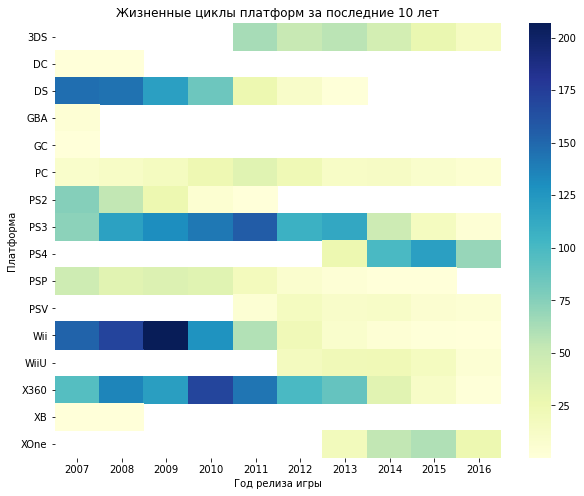

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_platforms, cmap='YlGnBu', annot=False)
plt.xlabel('Год релиза игры')
plt.ylabel('Платформа')
plt.title('Жизненные циклы платформ за последние 10 лет')

plt.yticks(rotation=0)
plt.show()

Наиболее перспективными платформами для продажи игр в 2017 году являются платформы, которые находятся в начале или середине своего жизненного цикла. А именно: _3DS, PS4, PSV, WiiU_ и _XOne_.

---

---
Рассмотрим выручку по актуальным платформам и построим для них диаграммы _boxplot_.

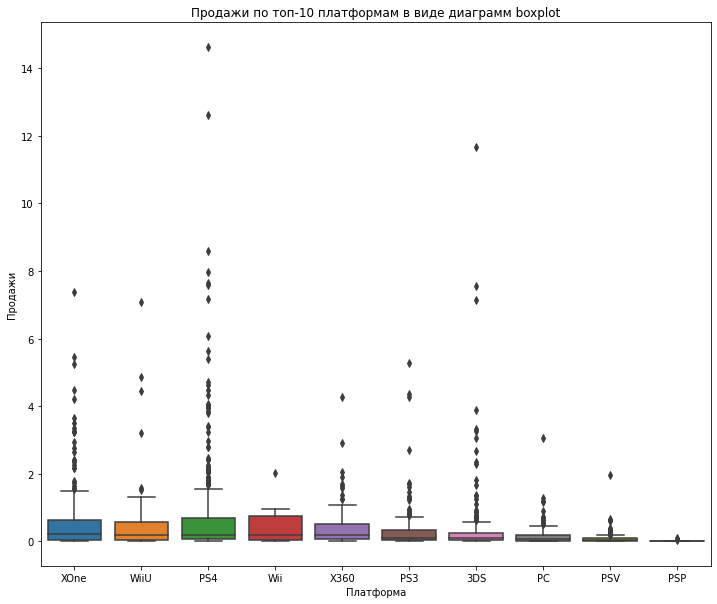

In [ ]:
plt.figure(figsize=(12, 10))

sorted_platforms = df_filtered.groupby('platform')['total_sales'].median().sort_values(ascending=False).index
sns.boxplot(x='platform', y='total_sales', data=df_filtered, order=sorted_platforms, showfliers=True)

plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.title('Продажи по топ-10 платформам в виде диаграмм boxplot')


plt.show()

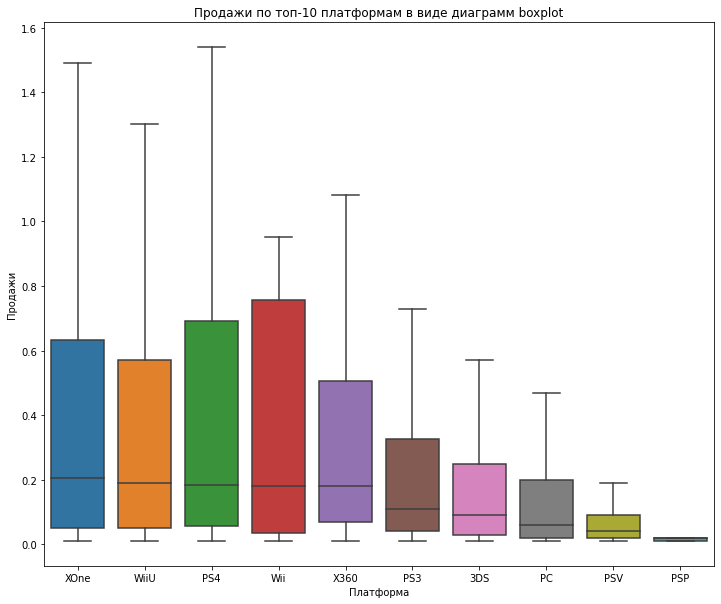

In [ ]:
plt.figure(figsize=(12, 10))

sns.boxplot(x='platform', y='total_sales', data=df_filtered, order=sorted_platforms, showfliers=False)

plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.title('Продажи по топ-10 платформам в виде диаграмм boxplot')


plt.show()

In [ ]:
platforms = df_filtered['platform'].unique().tolist()

for platform in platforms:
    print('Дисперсия', platform.upper(),':', np.var(df_filtered[df_filtered['platform']==platform]\
                                                    ['total_sales']).round(3))
    print('Стандартное отклонение', platform.upper(),':', np.std(df_filtered[df_filtered['platform']==platform]\
                                                    ['total_sales']).round(3))
    print('Среднее значение',platform.upper(),':',  df_filtered[df_filtered['platform']==platform]\
                                                    ['total_sales'].mean().round(3))
    print('Медиана',platform.upper(),':',  df_filtered[df_filtered['platform']==platform]\
                                                    ['total_sales'].median().round(3))
    print('\n')

Дисперсия PS4 : 2.601
Стандартное отклонение PS4 : 1.613
Среднее значение PS4 : 0.766
Медиана PS4 : 0.185


Дисперсия 3DS : 1.406
Стандартное отклонение 3DS : 1.186
Среднее значение 3DS : 0.409
Медиана 3DS : 0.09


Дисперсия XONE : 1.09
Стандартное отклонение XONE : 1.044
Среднее значение XONE : 0.616
Медиана XONE : 0.205


Дисперсия WIIU : 1.331
Стандартное отклонение WIIU : 1.153
Среднее значение WIIU : 0.589
Медиана WIIU : 0.19


Дисперсия PS3 : 0.399
Стандартное отклонение PS3 : 0.632
Среднее значение PS3 : 0.311
Медиана PS3 : 0.11


Дисперсия X360 : 0.392
Стандартное отклонение X360 : 0.626
Среднее значение X360 : 0.434
Медиана X360 : 0.18


Дисперсия PC : 0.108
Стандартное отклонение PC : 0.328
Среднее значение PC : 0.179
Медиана PC : 0.06


Дисперсия WII : 0.356
Стандартное отклонение WII : 0.596
Среднее значение WII : 0.461
Медиана WII : 0.18


Дисперсия PSV : 0.02
Стандартное отклонение PSV : 0.141
Среднее значение PSV : 0.076
Медиана PSV : 0.04


Дисперсия PSP : 0.001
Стандар

Как видим, наибольшая медиана - у платформы _XOne_, а наибольшее среднее значение - у платформы _PS4_.

---


### Как влияют на продажи внутри одной платформы отзывы пользователей и критиков?

Рассмотрим 3 крупнейшие платформы.  


Сначала рассмотрим платформу **PS4**.

In [ ]:
df_ps4 = df_filtered[df_filtered['platform']=='PS4']

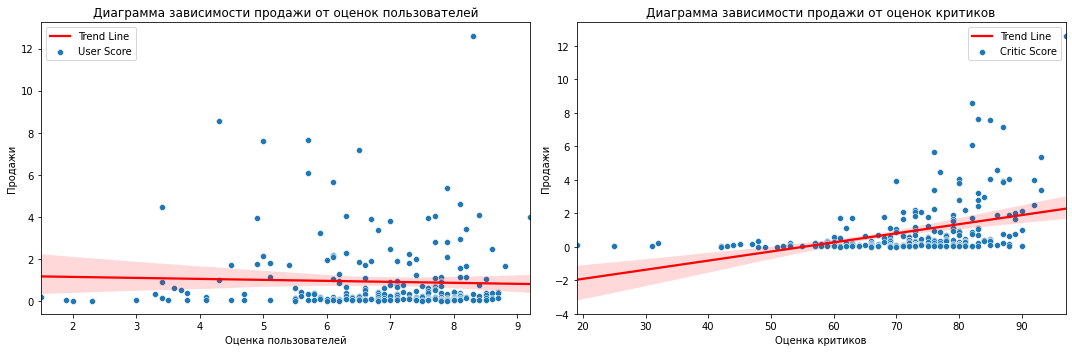

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x='user_score', y='total_sales', data=df_ps4, label='User Score', ax=axes[0])
sns.regplot(x='user_score', y='total_sales', data=df_ps4, scatter=False, label='Trend Line', color='red', ax=axes[0])

axes[0].set_xlabel('Оценка пользователей')
axes[0].set_ylabel('Продажи')
axes[0].set_title('Диаграмма зависимости продажи от оценок пользователей')
axes[0].legend()

sns.scatterplot(x='critic_score', y='total_sales', data=df_ps4, label='Critic Score', ax=axes[1])
sns.regplot(x='critic_score', y='total_sales', data=df_ps4, scatter=False, label='Trend Line', color='red', ax=axes[1])

axes[1].set_xlabel('Оценка критиков')
axes[1].set_ylabel('Продажи')
axes[1].set_title('Диаграмма зависимости продажи от оценок критиков')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
#Корреляция между оценками и продажами

print('Корреляция между оценками пользователей и продажами через платформу PS4:',
      df_ps4['user_score'].corr(df_ps4['total_sales']).round(3))
print('Корреляция между оценками критиков и продажами через платформу PS4:',
      df_ps4['critic_score'].corr(df_ps4['total_sales']).round(3))

Корреляция между оценками пользователей и продажами через платформу PS4: -0.04
Корреляция между оценками критиков и продажами через платформу PS4: 0.403


Выручка по данной платформе не коррелирует с оценками пользователей.  
Корреляция между выручкой и оценками критиков - положительная слабая.

---

Посмотрим аналогичные параметры для платформы **XOne**.

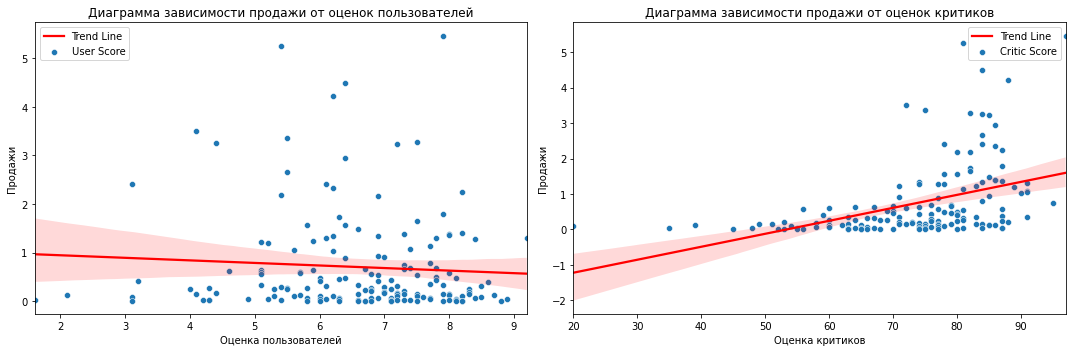

In [ ]:
df_xone = df_filtered[df_filtered['platform']=='XOne']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x='user_score', y='total_sales', data=df_xone, label='User Score', ax=axes[0])
sns.regplot(x='user_score', y='total_sales', data=df_xone, scatter=False, label='Trend Line', color='red', ax=axes[0])

axes[0].set_xlabel('Оценка пользователей')
axes[0].set_ylabel('Продажи')
axes[0].set_title('Диаграмма зависимости продажи от оценок пользователей')
axes[0].legend()

sns.scatterplot(x='critic_score', y='total_sales', data=df_xone, label='Critic Score', ax=axes[1])
sns.regplot(x='critic_score', y='total_sales', data=df_xone, scatter=False, label='Trend Line', color='red', ax=axes[1])

axes[1].set_xlabel('Оценка критиков')
axes[1].set_ylabel('Продажи')
axes[1].set_title('Диаграмма зависимости продажи от оценок критиков')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
print('Корреляция между оценками пользователей и продажами через платформу XOne:',
      df_xone['user_score'].corr(df_xone['total_sales']).round(3))
print('Корреляция между оценками критиков и продажами через платформу XOne:',
      df_xone['critic_score'].corr(df_xone['total_sales']).round(3))

Корреляция между оценками пользователей и продажами через платформу XOne: -0.07
Корреляция между оценками критиков и продажами через платформу XOne: 0.429


Здесь картина аналогичная - корреляция между выручкой и оценками пользователей отсутствует, корреляция между выручкой и оценками критиков - положительная слабая.

---

Посмотрим аналогичные параметры для платформы **3DS**.

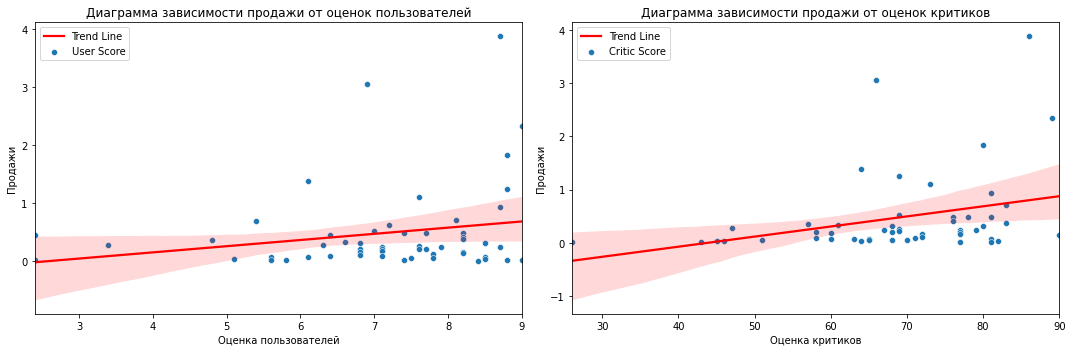

In [ ]:
df_3ds = df_filtered[df_filtered['platform']=='3DS']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x='user_score', y='total_sales', data=df_3ds, label='User Score', ax=axes[0])
sns.regplot(x='user_score', y='total_sales', data=df_3ds, scatter=False, label='Trend Line', color='red', ax=axes[0])

axes[0].set_xlabel('Оценка пользователей')
axes[0].set_ylabel('Продажи')
axes[0].set_title('Диаграмма зависимости продажи от оценок пользователей')
axes[0].legend()

sns.scatterplot(x='critic_score', y='total_sales', data=df_3ds, label='Critic Score', ax=axes[1])
sns.regplot(x='critic_score', y='total_sales', data=df_3ds, scatter=False, label='Trend Line', color='red', ax=axes[1])

axes[1].set_xlabel('Оценка критиков')
axes[1].set_ylabel('Продажи')
axes[1].set_title('Диаграмма зависимости продажи от оценок критиков')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
print('Корреляция между оценками пользователей и продажами через платформу 3DS:',
      df_3ds['user_score'].corr(df_3ds['total_sales']).round(3))
print('Корреляция между оценками критиков и продажами через платформу 3DS:',
      df_3ds['critic_score'].corr(df_3ds['total_sales']).round(3))

Корреляция между оценками пользователей и продажами через платформу 3DS: 0.215
Корреляция между оценками критиков и продажами через платформу 3DS: 0.314




---

Можем сделать общий вывод, что оценки пользователей не имеют очевидной корреляции с продажами игр (коэффициент корреляции менее 0,25).   
Оценки критиков имеют слабую положительную корреляцию с продажами игр (коэффициент корреляции в диапазоне от 0,25 до 0,5).

### Какие жанры самые прибыльные?

In [ ]:
df_genres = df_filtered.groupby('genre')\
            .agg({'name': 'count', 'total_sales': 'sum'})\
            .reset_index()\
            .sort_values(by='total_sales', ascending=False)

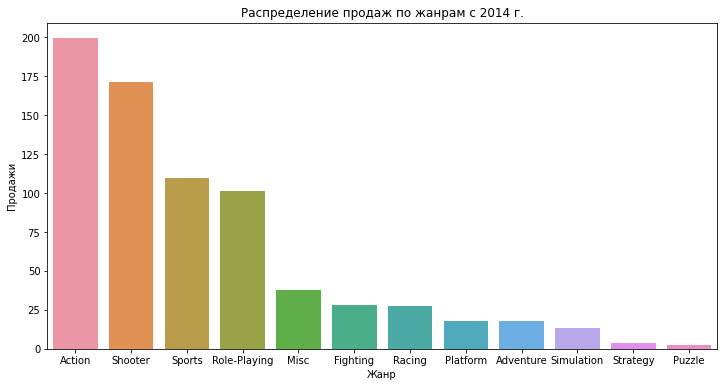

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='genre', y='total_sales', data=df_genres)

plt.xlabel('Жанр')
plt.ylabel('Продажи')
plt.title('Распределение продаж по жанрам с 2014 г.')

plt.show()

Среди наиболее популярных жанров лидирует жанр _"Action"_. Также в тройке наиболее популярных - _"Shooter"_ и _"Sports"_.  

Наименее прибыльный жанр - _"Puzzle"_.

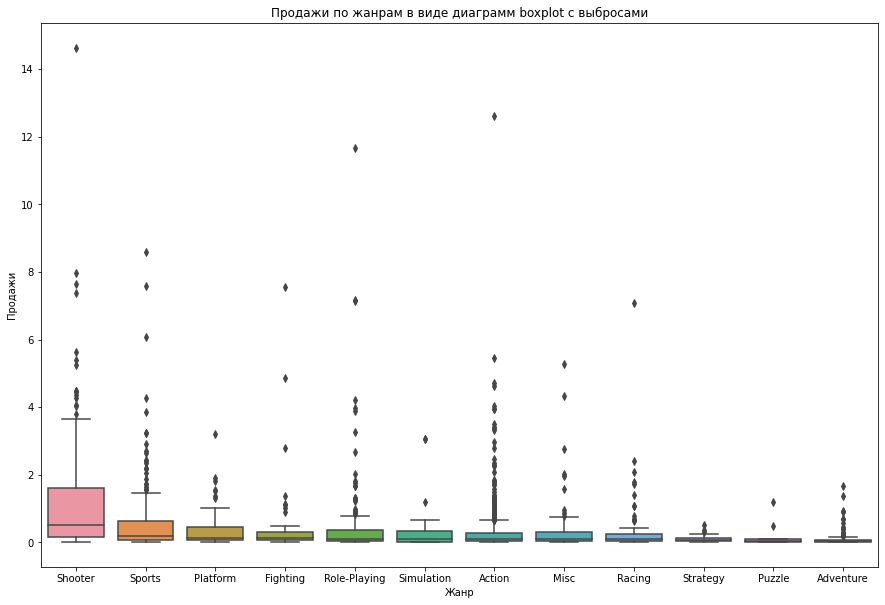

In [ ]:
plt.figure(figsize=(15, 10))

sorted_genres = df_filtered.groupby('genre')['total_sales'].median().sort_values(ascending=False).index
sns.boxplot(x='genre', y='total_sales', data=df_filtered, order=sorted_genres, showfliers=True)

plt.xlabel('Жанр')
plt.ylabel('Продажи')
plt.title('Продажи по жанрам в виде диаграмм boxplot с выбросами')


plt.show()

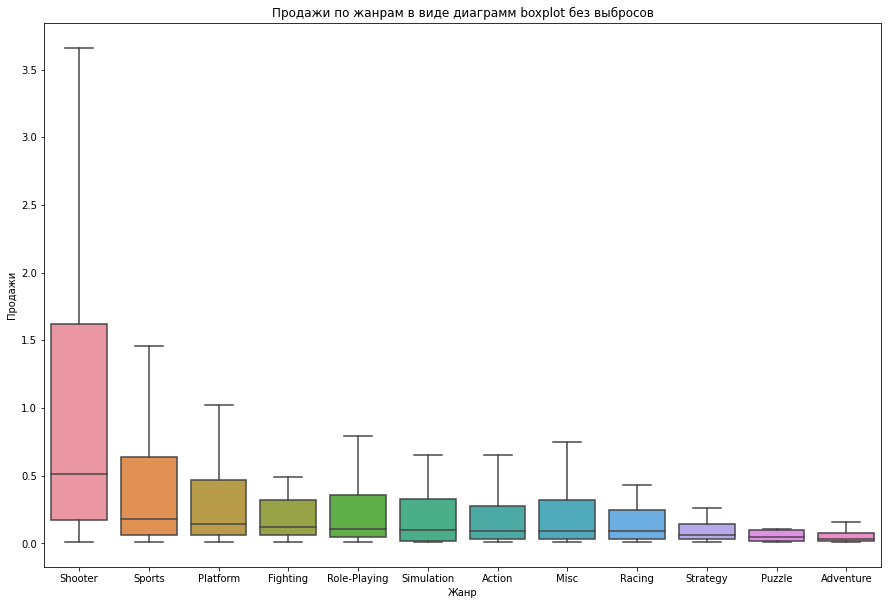

In [ ]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='genre', y='total_sales', data=df_filtered, order=sorted_genres, showfliers=False)
plt.xlabel('Жанр')
plt.ylabel('Продажи')
plt.title('Продажи по жанрам в виде диаграмм boxplot без выбросов')


plt.show()

In [ ]:
genres = df_filtered['genre'].unique().tolist()

for genre in genres:
    print('Дисперсия', genre.upper(),':', np.var(df_filtered[df_filtered['genre']==genre]\
                                                    ['total_sales']).round(3))
    print('Стандартное отклонение', genre.upper(),':', np.std(df_filtered[df_filtered['genre']==genre]\
                                                    ['total_sales']).round(3))
    print('Среднее значение',genre.upper(),':',  df_filtered[df_filtered['genre']==genre]\
                                                    ['total_sales'].mean().round(3))
    print('Медиана',genre.upper(),':',  df_filtered[df_filtered['genre']==genre]\
                                                    ['total_sales'].median().round(3))
    print('\n')

Дисперсия SHOOTER : 4.172
Стандартное отклонение SHOOTER : 2.043
Среднее значение SHOOTER : 1.335
Медиана SHOOTER : 0.515


Дисперсия ACTION : 0.636
Стандартное отклонение ACTION : 0.798
Среднее значение ACTION : 0.322
Медиана ACTION : 0.09


Дисперсия ROLE-PLAYING : 1.38
Стандартное отклонение ROLE-PLAYING : 1.175
Среднее значение ROLE-PLAYING : 0.459
Медиана ROLE-PLAYING : 0.11


Дисперсия SPORTS : 1.527
Стандартное отклонение SPORTS : 1.236
Среднее значение SPORTS : 0.68
Медиана SPORTS : 0.18


Дисперсия FIGHTING : 1.388
Стандартное отклонение FIGHTING : 1.178
Среднее значение FIGHTING : 0.47
Медиана FIGHTING : 0.125


Дисперсия RACING : 0.915
Стандартное отклонение RACING : 0.957
Среднее значение RACING : 0.399
Медиана RACING : 0.09


Дисперсия MISC : 0.538
Стандартное отклонение MISC : 0.734
Среднее значение MISC : 0.332
Медиана MISC : 0.09


Дисперсия PLATFORM : 0.508
Стандартное отклонение PLATFORM : 0.713
Среднее значение PLATFORM : 0.476
Медиана PLATFORM : 0.14


Дисперсия SIM

Как мы видим, наибольшие медианные и средние продажи у жанра `Shooter`.  
Этот же жанр имеет более длинный ряд успешно продающихся игр.

---

**Резюме подраздела:**
- рост количества выпускаемых игр начался с 1990 года,
- в 2008-2009 годах был пик количества выпускаемых игр - более 1400 игр ежегодно,
- платформы с наибольшими суммарными продажами: _PS42, XOne, 3DS_,
- платформы, как правило, имеют свои жизненные циклы длительностью около 10 лет,
- пик продаж игр приходится, как правило, на середину жизненного цикла платформы,
- наиболее перспективными платформами для продажи игр в 2017 году являются платформы, которые находятся в начале или середине своего жизненного цикла: _3DS, PS4, WiiU и XOne_,
- наиболее высокая медианная выручка:
    - у платформы _XOne_,
    - у жанра _Shooter_.

## Портрет пользователя каждого региона

### Самые популярные платформы

In [ ]:
def calculate_top_platforms(df, sales_column):
    platforms = df.groupby('platform').agg({sales_column: 'sum'})\
        .reset_index().sort_values(by=sales_column, ascending=False)

    top5 = platforms.nlargest(5, sales_column)
    other_sum = platforms[5:][sales_column].sum()

    other_row = pd.DataFrame({'platform': ['Other'], sales_column: [other_sum]})
    platforms = pd.concat([top5, other_row])

    return platforms

sales_columns = ['na_sales', 'eu_sales', 'jp_sales']
regions = ['Северная америка', 'Европа', 'Япония']

for i in range(len(sales_columns)):
    platforms_data = calculate_top_platforms(df_filtered, sales_columns[i])
    print(f"Выручка от продаж по платформам \n в регионе {regions[i]}:")
    display(platforms_data)
    print()

Выручка от продаж по платформам 
 в регионе Северная америка:


,platform,na_sales
3,PS4,98.61
9,XOne,81.27
8,X360,28.30
0,3DS,22.64
2,PS3,22.05
0,Other,31.19



Выручка от продаж по платформам 
 в регионе Европа:


,platform,eu_sales
3,PS4,130.04
9,XOne,46.25
2,PS3,25.54
1,PC,17.97
0,3DS,16.12
0,Other,34.76



Выручка от продаж по платформам 
 в регионе Япония:


,platform,jp_sales
0,3DS,44.24
3,PS4,15.02
5,PSV,14.54
2,PS3,11.22
7,WiiU,7.31
0,Other,0.76


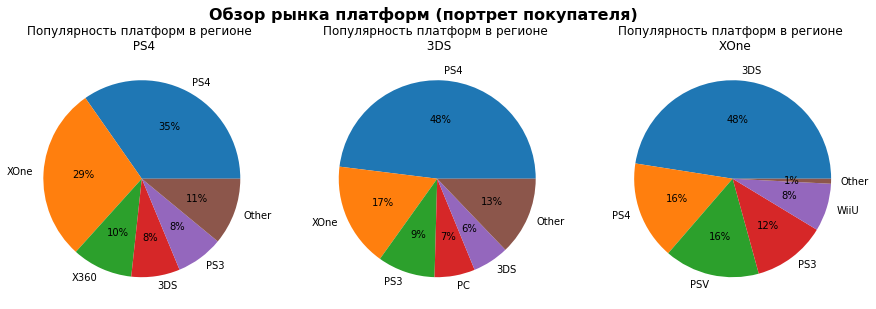

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(len(sales_columns)):
    platforms_data = calculate_top_platforms(df_filtered, sales_columns[i])
    labels = platforms_data['platform']
    values = platforms_data[sales_columns[i]]

    axs[i].pie(values, labels=labels, autopct='%1.f%%')
    axs[i].set_title(f"Популярность платформ в регионе \n {platforms[i]}")

fig.suptitle("Обзор рынка платформ (портрет покупателя)", fontsize=16, fontweight='bold')

plt.show()


### Самые популярные жанры

In [ ]:
def calculate_top_genres(df, sales_column):
    genres = df.groupby('genre').agg({sales_column: 'sum'})\
        .reset_index().sort_values(by=sales_column, ascending=False)

    top5 = genres.nlargest(5, sales_column)
    other_sum = genres[5:][sales_column].sum()

    other_row = pd.DataFrame({'genre': ['Other'], sales_column: [other_sum]})
    genres = pd.concat([top5, other_row])

    return genres



for i in range(len(sales_columns)):
    genres_data = calculate_top_genres(df_filtered, sales_columns[i])
    print(f"Выручка от продаж по жанрам \n в регионе {regions[i]}:")
    display(genres_data)
    print()


Выручка от продаж по жанрам 
 в регионе Северная америка:


,genre,na_sales
8,Shooter,79.02
0,Action,72.53
10,Sports,46.13
7,Role-Playing,33.47
3,Misc,15.05
0,Other,37.86



Выручка от продаж по жанрам 
 в регионе Европа:


,genre,eu_sales
0,Action,74.68
8,Shooter,65.52
10,Sports,45.73
7,Role-Playing,28.17
6,Racing,14.13
0,Other,42.45



Выручка от продаж по жанрам 
 в регионе Япония:


,genre,jp_sales
7,Role-Playing,31.16
0,Action,29.58
2,Fighting,6.37
3,Misc,5.61
8,Shooter,4.87
0,Other,15.50


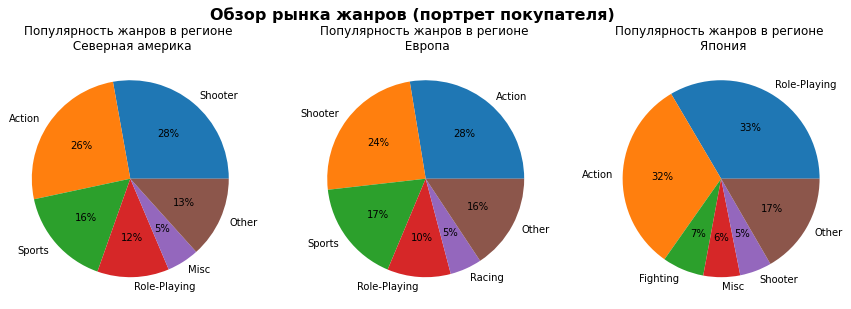

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(len(sales_columns)):
    genres_data = calculate_top_genres(df_filtered, sales_columns[i])
    labels = genres_data['genre']
    values = genres_data[sales_columns[i]]

    axs[i].pie(values, labels=labels, autopct='%1.f%%')
    axs[i].set_title(f"Популярность жанров в регионе \n {regions[i]}")

fig.suptitle("Обзор рынка жанров (портрет покупателя)", fontsize=16, fontweight='bold')

plt.show()

### Самые популярные рейтинги игр

In [ ]:
def calculate_top_ratings(df, sales_column):
    ratings = df.groupby('rating').agg({sales_column: 'sum'})\
        .reset_index().sort_values(by=sales_column, ascending=False)

    top5 = ratings.nlargest(5, sales_column)
    other_sum = ratings[5:][sales_column].sum()

    other_row = pd.DataFrame({'rating': ['Other'], sales_column: [other_sum]})
    ratings = pd.concat([top5, other_row])

    return ratings


for i in range(len(sales_columns)):
    ratings_data = calculate_top_ratings(df_filtered, sales_columns[i])
    print(f"Выручка от продаж по жанрам \n в регионе {regions[i]}:")
    display(ratings_data)
    print()

Выручка от продаж по жанрам 
 в регионе Северная америка:


,rating,na_sales
2,M,96.42
3,RP,64.72
0,E,50.74
4,T,38.95
1,E10+,33.23
0,Other,0.00



Выручка от продаж по жанрам 
 в регионе Европа:


,rating,eu_sales
2,M,93.44
3,RP,58.95
0,E,58.06
4,T,34.07
1,E10+,26.16
0,Other,0.00



Выручка от продаж по жанрам 
 в регионе Япония:


,rating,jp_sales
3,RP,56.90
4,T,14.78
0,E,8.94
2,M,8.01
1,E10+,4.46
0,Other,0.00


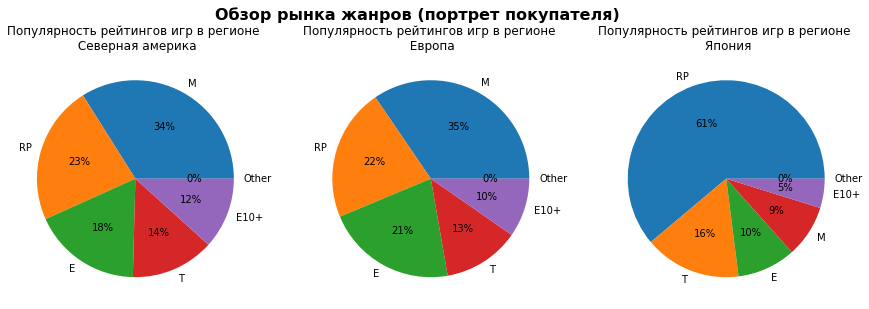

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(len(sales_columns)):
    ratings_data = calculate_top_ratings(df_filtered, sales_columns[i])
    labels = ratings_data['rating']
    values = ratings_data[sales_columns[i]]

    axs[i].pie(values, labels=labels, autopct='%1.f%%')
    axs[i].set_title(f"Популярность рейтингов игр в регионе \n {regions[i]}")

fig.suptitle("Обзор рынка жанров (портрет покупателя)", fontsize=16, fontweight='bold')

plt.show()

**Резюме подраздела:**

1. В регионе **NA** самые прибыльные по продажам игр:
- платформы - _PS4, XOne, X360_,
- жанры - _Shooter, Action, Sports_,
- рейтинги - _M, RP (без рейтинга), E_.

2. В регионе **EU** самые прибыльные по продажам игр:
- платформы - _PS4, XOne, PS3_,
- жанры - _Action, Shooter, Sports_,
- рейтинги - _M, RP (без рейтинга), E_.

3. В регионе **JP** самые прибыльные по продажам игр:
- платформы - _3DS, PS4, PSV_,
- жанры - _Role-Playing, Action, Fighting_,
- рейтинги - _RP (без рейтинга), T, E_.

---

## Проверим гипотезы

### Сравним средние пользовательские рейтинги платформ Xbox One и PC.

Проверим двустороннюю гипотезу о равенстве среднего двух генеральных совокупностей при помощи t-теста.

**Нулевая гипотеза H0:** Средние пользовательские рейтинги платформ Xbox One и PC равны.  
**Альтернативная гипотеза H1:** Средние пользовательские рейтинги платформ Xbox One и PC не равны.

Как мы ранее обнаружили, платформа `XOne` выпускается с 2013 года, а платформа `PC` уже довольно старая.  
Для лучшей сопоставимости возьмем данные для платформы `PC` с 2013 года.

In [ ]:
# Зададим наборы значений, которые содержат выборки.
array1 = df_filtered[df_filtered['platform'] == 'XOne']['user_score'].dropna().tolist()
array2 = df_filtered[(df_filtered['platform'] == 'PC') & (df_filtered['year_of_release'] >= 2013)]\
                                                        ['user_score'].dropna().tolist()

In [ ]:
print('Среднее значение user_score по платформе XOne:', np.mean(array1).round(2))
print('Среднее значение user_score по платформе XOne:', np.mean(array2).round(2))

Среднее значение user_score по платформе XOne: 6.59
Среднее значение user_score по платформе XOne: 6.3


In [ ]:
# Зададим уровень статистической значимости
alpha = 0.05

results = st.ttest_ind(array1, array2)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


p-значение = 0.1045 и больше порогового значения alpha. Это означает, что при условии, что нулевая гипотеза верна, вероятность получить наблюдаемые данные или более экстремальные результаты равна примерно 0.1045.


Мы принимаем нулевую гипотезу о равенстве средних пользовательских рейтингов платформ Xbox One и PC, поскольку их статистически значимая разница не обнаружена.

---

### Сравним средние пользовательские рейтинги жанров Action и Sports.

Проверим двустороннюю гипотезу о равенстве среднего двух генеральных совокупностей при помощи t-теста.

**Нулевая гипотеза H0:** Средние пользовательские рейтинги  жанров Action и Sports равны.  
**Альтернативная гипотеза H1:** Средние пользовательские рейтинги жанров Action и Sports не равны.

In [ ]:
# Зададим наборы значений, которые содержат выборки.
array3 = df_filtered[df_filtered['genre'] == 'Action']['user_score'].dropna().tolist()
array4 = df_filtered[df_filtered['genre'] == 'Sports']['user_score'].dropna().tolist()

In [ ]:
print('Среднее значение user_score по жанру Action:', np.mean(array3).round(2))
print('Среднее значение user_score по жанру Sports:', np.mean(array4).round(2))

Среднее значение user_score по жанру Action: 6.76
Среднее значение user_score по жанру Sports: 5.23


In [ ]:
# Зададим уровень статистической значимости
alpha = 0.05

results = st.ttest_ind(array3, array4)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.8711147985105864e-19
Отвергаем нулевую гипотезу


Есть статистически значимое отличие между средними значениями двух генеральных совокупностей, поэтому мы отвергаем нулевую гипотезу и склоняемся в пользу альтернативной. Мы считаем, что средние пользовательские рейтинги жанров Action и Sports имеют статистически значимое различие.

**Резюме подраздела:**
- Есть основания считать, что средние пользовательские рейтинги платформ Xbox One и PC равны.
- Есть основания считать, что средние пользовательские рейтинги жанров Action и Sports не равны.

## Выводы

1. Мы ознакомились с имеющимися данными и провели предварительную обработку:

 - в файле 16715 строк и 11 колонок,
 - данные представлены в диапазоне с 1980 по 2016 годы,
 - строк-полных дубликатов нет,
 - подозрительных значений количественных переменных нет,
 - избавились от неявных дубликатов в категориальных переменных (24 неявных дубликата в названиях игр),
 - скорректировали названия колонок в соответствии со snake_case,
 - скорректировали типы данных двух колонок,
 - обнаружили, что у 14 платформ отсутствуют оценки критиков и пользоватлелей,
 - в колонке `user_score` заменили обозначения _tbd_ на _NaN_,
 - в 6 колонках есть пропуски,
 - часть пропусков, которые можно было заполнить, мы заполнили, остальные - оставили,
 - создали колонку `total_sales` с суммарными продажами по всем регионам.



2. Провели исследовательский анализ данных:
- с 1990 года начался рост количества выпускаемых игр,
- в 2008-2009 годах был пик количества выпускаемых игр - более 1400 игр ежегодно,
- после этого количество релизов игр начало уменьшаться. Возможные причины:
    - уменьшение потребительского спроса,
    - трудности экономического характера (например, вследствие глобального экономического кризиса),
    - переток пользователей в мобильные игры на самртфонах.
- определили актуальный период для последующего анализа - с 2014 по 2016 г.
- платформы с наибольшими суммарными продажами в актуальном периоде: _PS42, XOne, 3DS_,
- максимальные годовые продажи были в 2004 году через платформу _PS2_ - 211,8 млн. копий,
- выявили жизненные циклы платформ - они составляют около 10 лет с пиком продаж в середине цикла,
- наиболее перспективные платформы для продажи игр в 2017 году - _3DS, PS4, PSV, WiiU и XOne_. Они находятся в начале или середине своего жизненного цикла,
- оценки пользователей не имеют очевидной корреляции с продажами игр (коэффициент корреляции менее 0,25),   
- оценки критиков имеют слабую положительную корреляцию с продажами игр (коэффициент корреляции в диапазоне от 0,25 до 0,5),
- за актуальный период - наиболее высокие медианные продажи:
    - у платформы _XOne_,
    - у жанра _Shooter_.
- наиболее прибыльные жанры игр - _Action, Shooter и Sports_.


3. Составили портрет пользователя каждого региона и определили, что самые прибыльные по продажам игр:
    1. В регионе **NA** самые прибыльные по продажам игр:
        - платформы - _PS4, XOne, X360_ - в сумме 74% на локальном рынке,
        - жанры - _Shooter, Action, Sports_ - в сумме 70%,
        - рейтинги - _M, RP (без рейтинга), E_ - в сумме 75%.

    2. В регионе **EU** самые прибыльные по продажам игр:
        - платформы - _PS4, XOne, PS3_ - в сумме 74%,
        - жанры - _Action, Shooter, Sports_ - в сумме 69%,
        - рейтинги - _M, RP (без рейтинга), E_ - в сумме 78%.

    3. В регионе **JP** самые прибыльные по продажам игр:
        - платформы - _3DS, PS4, PSV_ - в сумме 80%,
        - жанры - _Role-Playing, Action, Fighting_ - в сумме 72%,
        - рейтинги - _RP (без рейтинга), T, E_ - в сумме 87%.


4. Выдвинули и проверили гипотезы, в результате чего пришли к заключению:
- есть основания считать, что средние пользовательские рейтинги платформ _Xbox One и PC_ равны.
- есть основания считать, что средние пользовательские рейтинги жанров _Action и Sports_ не равны.